# 決定木とランダムフォレスト（Random Forests）

原作者のJoseさんのブログをまずはご覧ください。
[こちら](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411)


Pythonをつかって、決定木とランダムフォレストの世界を探検してみましょう。

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [3]:
plt.style.use('seaborn-whitegrid')
#sns.set_style('whitegrid')


## ランダムフォレスト分類器

ランダムフォレスト（Random forests）は、アンサンブル学習法の一つです。アンサンブル学習法は、いくつかの分類器を集めて構成されるものですが、ここでは決定木が使われます。（木が集まるから森というわけです）

In [4]:
# 架空のデータを用意します。
from sklearn.datasets import make_blobs

In [6]:
# centers中心点、cluster_std標準偏差 <- ランダムに並ぶデータセットのばらつき
X, y = make_blobs(n_samples=500, centers=4, random_state=8, cluster_std=2.4)

In [7]:
X

array([[  8.031223  ,   1.07684647],
       [  0.79275323,  -8.49270872],
       [ -6.24741713,  -2.80979462],
       [  7.1350517 ,  -0.27620621],
       [  8.75371186,  12.16955042],
       [ -6.52850085,  -4.81571386],
       [ -5.68423308,  -8.6536682 ],
       [ -4.40557029, -10.14011553],
       [ -7.18713979,  -8.49782188],
       [  7.67125718,  15.33780796],
       [  7.05472091,   2.71136019],
       [ -6.44972594,  -8.50218035],
       [  7.3175591 ,   8.07104895],
       [  9.435827  ,  12.60240072],
       [ -3.94302873,  -8.45858333],
       [ -5.82070544, -11.54252584],
       [  5.45439833,  10.04943649],
       [  1.23496178,  -4.95053236],
       [  0.99142387,  -0.34084278],
       [ -4.89204127,  -6.95668615],
       [  6.09686891,   6.03480565],
       [ -0.70549841,  -3.44748449],
       [ -0.18012153,  -2.11546643],
       [ -3.20156642, -10.44698102],
       [  0.95069301,  -2.56593727],
       [ -0.75648703,   0.73537406],
       [ -0.74705664,   1.54560469],
 

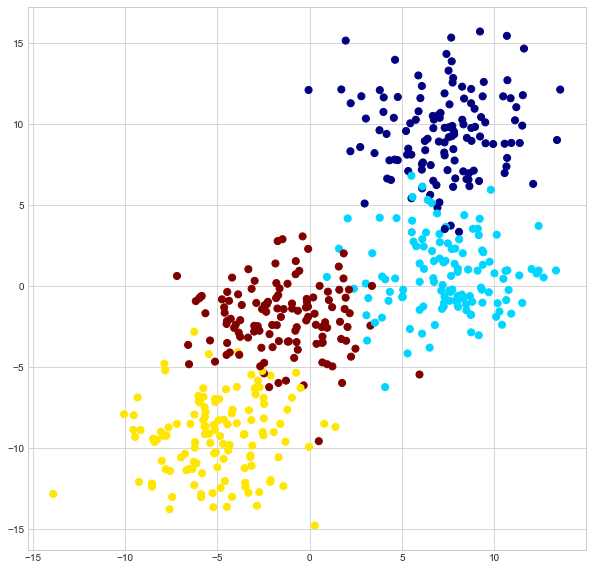

In [10]:
#Scatter plot the points
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='jet')

In [11]:
from sklearn.tree import DecisionTreeClassifier

### 描画のための関数

In [12]:
def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    '''
    決定木の可視化をします。
    INPUTS: 分類モデル, X, y, optional x/y limits.
    OUTPUTS: Meshgridを使った決定木の可視化
    '''
    # fitを使ったモデルの構築
    classifier.fit(X, y)
    
    # 軸を自動調整
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    
    
    # meshgridをつくります。
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 分類器の予測をZとして保存
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # meshgridを使って、整形します。
    Z = Z.reshape(xx.shape)
    
    # 分類ごとに色を付けます。
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')
    
    # 訓練データも描画します。
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    
    def plot_boundaries(i, xlim, ylim):
        '''
        境界線を描き込みます。
        '''
        if i < 0:
            return

        tree = classifier.tree_
        
        # 境界を描画するために、再帰的に呼び出します。
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
    
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

深さ2までのプロットを描いて見ます。

In [14]:
clf = DecisionTreeClassifier(max_depth=2, random_state=0)

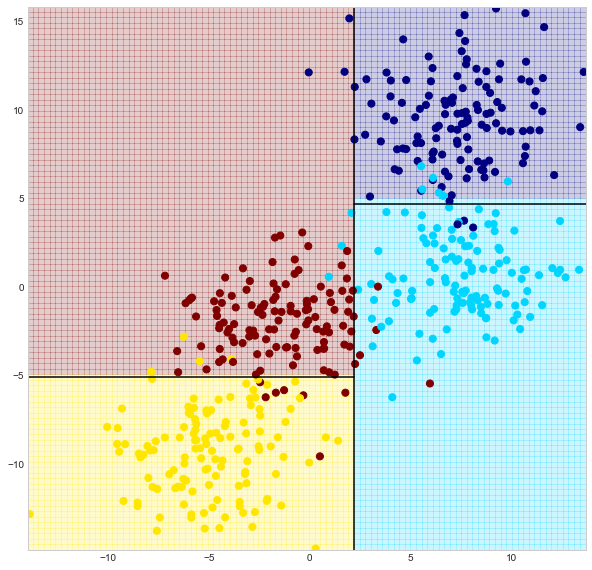

In [16]:
# 描画
visualize_tree(clf, X, y)

** 深さを4にしてみます**

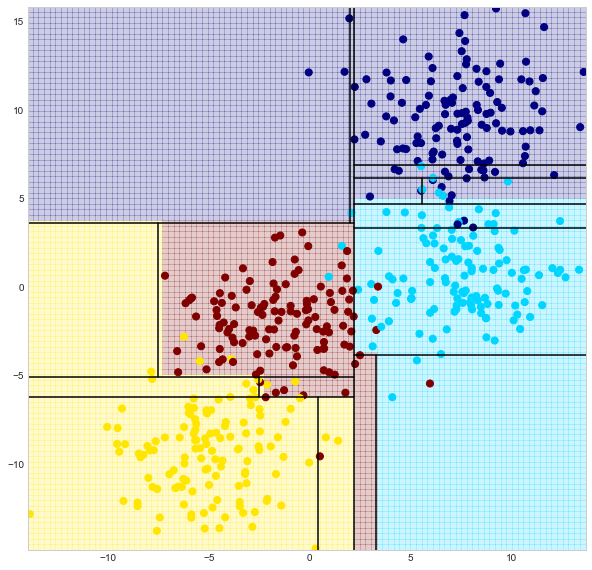

In [17]:
clf = DecisionTreeClassifier(max_depth=4, random_state=0)
visualize_tree(clf, X, y)

あまりにも細かく分類すると、過学習（over fitting）の問題が起こります。

## Random Forests

過学習の問題を回避するための一つの方法が、ランダムフォレストです。

ランダムフォレストは、学習データの一部をランダムに選んで、決定木を作ります。これを繰り返すことによって、色々な種類の木が出来るので、汎化性能が下がるのを避けることが出来るわけです。

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# n_estimatorsは、作る木の数です。
clf = RandomForestClassifier(n_estimators=100, random_state=0)

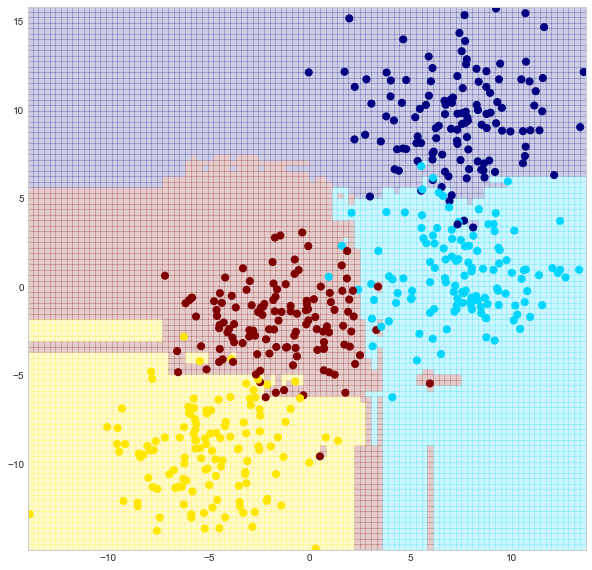

In [24]:
# 境界線を書かないようにします。
visualize_tree(clf, X, y, boundaries=False)



決定木とは違った境界線が描かれているのがわかります。
​
## Random Forest Regression
ランダムフォレストは、分類だけではなく、回帰にも使うことができます。
​
ダミーのデータを作って、試してみましょう。


In [25]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def sin_model(x, sigma=0.2):
    '''
    大きな波＋小さな波＋ノイズからなるダミーデータです。
    '''
   
    noise = sigma * np.random.randn(len(x))

    return np.sin(5 * x) + np.sin(0.5 * x) + noise


In [28]:
# xからyを計算
y = sin_model(x)
y

array([-0.26793796, -1.31910346,  1.42269764,  0.13975745,  1.29056514,
        0.95121696,  1.03664919, -0.27554569, -1.23133956, -0.08802081,
        1.85879281,  1.81329132,  1.48747106,  0.25948286,  0.69417367,
        0.15125984, -0.10973729, -1.38201956, -1.56379273,  1.38576935,
        1.2303063 ,  0.37024323,  0.35862363,  0.09505029,  0.08424232,
        1.97093139,  1.04735863, -1.68116672,  0.44712842,  0.20263045,
        1.35833181, -2.14461151,  1.72477814,  1.4942084 , -0.04058208,
       -0.66984242,  0.40122669, -0.25914013, -0.47300939,  0.0353648 ,
       -1.29093871,  1.33701378,  0.93101799, -1.62288369,  1.87286991,
        0.91938621, -0.28440423,  2.19339992,  0.85393964,  0.95397957,
        1.60071167, -0.04825155, -0.77565427, -0.50954572,  0.84450849,
        0.20434246, -1.98951741, -1.89704411, -0.9495004 , -0.53481667,
       -0.22323138,  1.39224612,  0.87631336,  1.51705731,  1.61328293,
        2.03118759, -1.90956831,  1.92389666, -0.07348066,  0.67

<Container object of 3 artists>

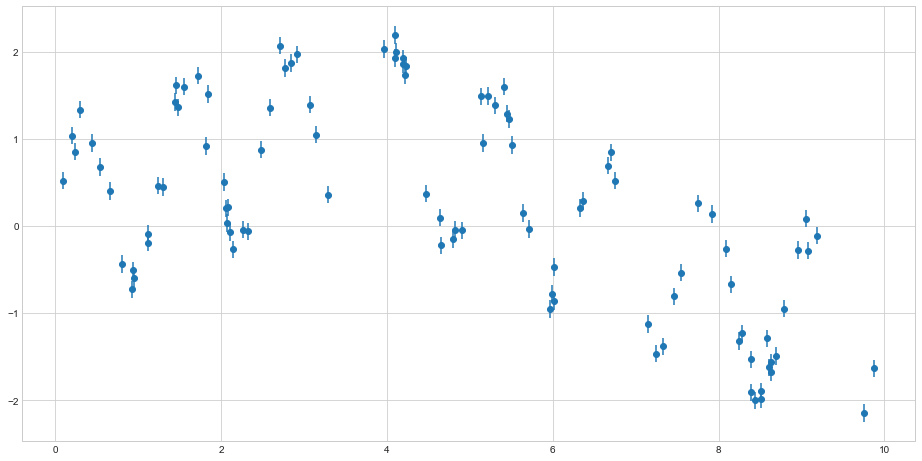

In [29]:
# Plotします。
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

このデータを単純な線形回帰で予測しようとしても難しいのは、一目瞭然です。
そこで、ランダムフォレストを使って見ることにしましょう。

In [30]:
xfit = np.linspace(0,10,1000)

In [31]:
rfr = RandomForestRegressor(100)

In [32]:
rfr.fit(x[:,None], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [33]:
yfit = rfr.predict(xfit[:,None])

In [41]:
yfit

array([ 0.70893505,  0.70893505,  0.70893505,  0.70893505,  0.70893505,
        0.70893505,  0.70893505,  0.70893505,  0.70893505,  0.70893505,
        0.70893505,  0.70893505,  0.70893505,  0.70893505,  0.70893505,
        0.91084455,  0.91084455,  0.95104541,  0.95104541,  0.95104541,
        0.98376866,  0.98376866,  0.9253016 ,  0.9253016 ,  0.9253016 ,
        0.98537452,  0.98537452,  1.14758814,  1.14758814,  1.14758814,
        1.14758814,  1.14758814,  1.14914609,  1.14402016,  1.15861176,
        1.15861176,  1.15861176,  1.00067381,  1.00067381,  0.98992109,
        0.98992109,  0.98992109,  0.90382387,  0.89746965,  0.89746965,
        0.88388826,  0.88388826,  0.88388826,  0.85581465,  0.72862951,
        0.69916166,  0.69916166,  0.69916166,  0.69916166,  0.69916166,
        0.66368652,  0.60318759,  0.60318759,  0.60318759,  0.60318759,
        0.46917218,  0.46917218,  0.46917218,  0.41365377,  0.41365377,
        0.41365377,  0.41365377,  0.28027728,  0.28027728,  0.21

In [42]:
ytrue = sin_model(xfit,0)

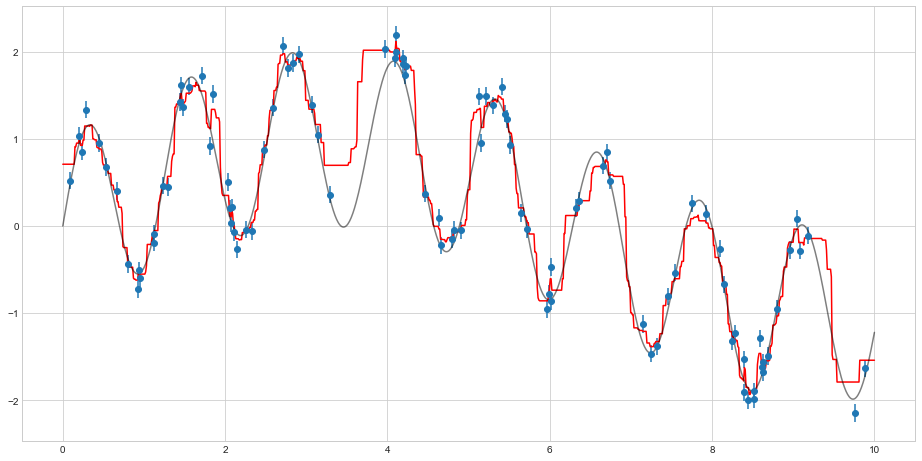

In [43]:
plt.figure(figsize=(16,8))

plt.errorbar(x,y,0.1,fmt='o')
plt.plot(xfit,yfit,'-r')
plt.plot(xfit,ytrue,'-k',alpha=0.5)

ランダムフォレストは、このように分類だけでは無く、回帰にも使えるので、非常に応用範囲が広い方法論です。
